In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict
import re
import orjson as json
from collections import defaultdict
import numpy as np

## Perf

In [ ]:
def get_last_symbol(callstack: List[Dict]) -> str:
    for call in reversed(callstack):
        if "symbol" in call:
            return call["symbol"]
    return ""

def parse(perf_json_file, mapping_file, identity) -> dict:
    with open(mapping_file) as f:
        mapping = json.loads(f.read())
    with open(perf_json_file) as f:
        data = json.loads(f.read())
    samples = data["samples"]
    classification = defaultdict(int)
    for sample in samples:
        if "comm" not in sample or sample["comm"] != identity:
            continue
        if "callchain" not in sample:
            continue
        symbol = get_last_symbol(sample["callchain"])
        for mpng, mpng_cat in mapping.items():
            if re.match(mpng[6:], symbol, re.IGNORECASE):
                classification[mpng_cat] += 1
    return classification

def cleaned_perf_up(perf_json_file, mapping_file, identity) -> dict:
    data = parse(perf_json_file, mapping_file, identity)
    new_data = defaultdict(int) 
    total = 0
    for key, value in data.items():
        retained = key.split(" ")[0]
        new_data[retained] += value
        total += value

    for key, value in new_data.items():
        new_data[key] = value / total * 100
    return new_data

def plot_distribution(ax: plt.Axes, dict: Dict[str, list], identity: str):
    labels, data = [], []
    for key, value in dict.items():
        labels.append(key)
        data.append(value)
    ax.bar(labels, data)
    ax.set_xticklabels(labels, rotation=90)
    ax.set(xlabel="", ylabel="CPU cycles (%)", title="Percentage of CPU cycles distribution : " + identity)

### Single Threaded

In [4]:
mpquic = {
    'conn::recv': 48.47, 
    'udp::recv_from': 29.16,
    'http::handle_response': 10.25,
    'udp::send_to': 5.78,
    'conn::send_on_path': 2.87,
}

/tmp/ipykernel_175370/763977083.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=30)


Text(0, 0.5, 'CPU cycles (%)')

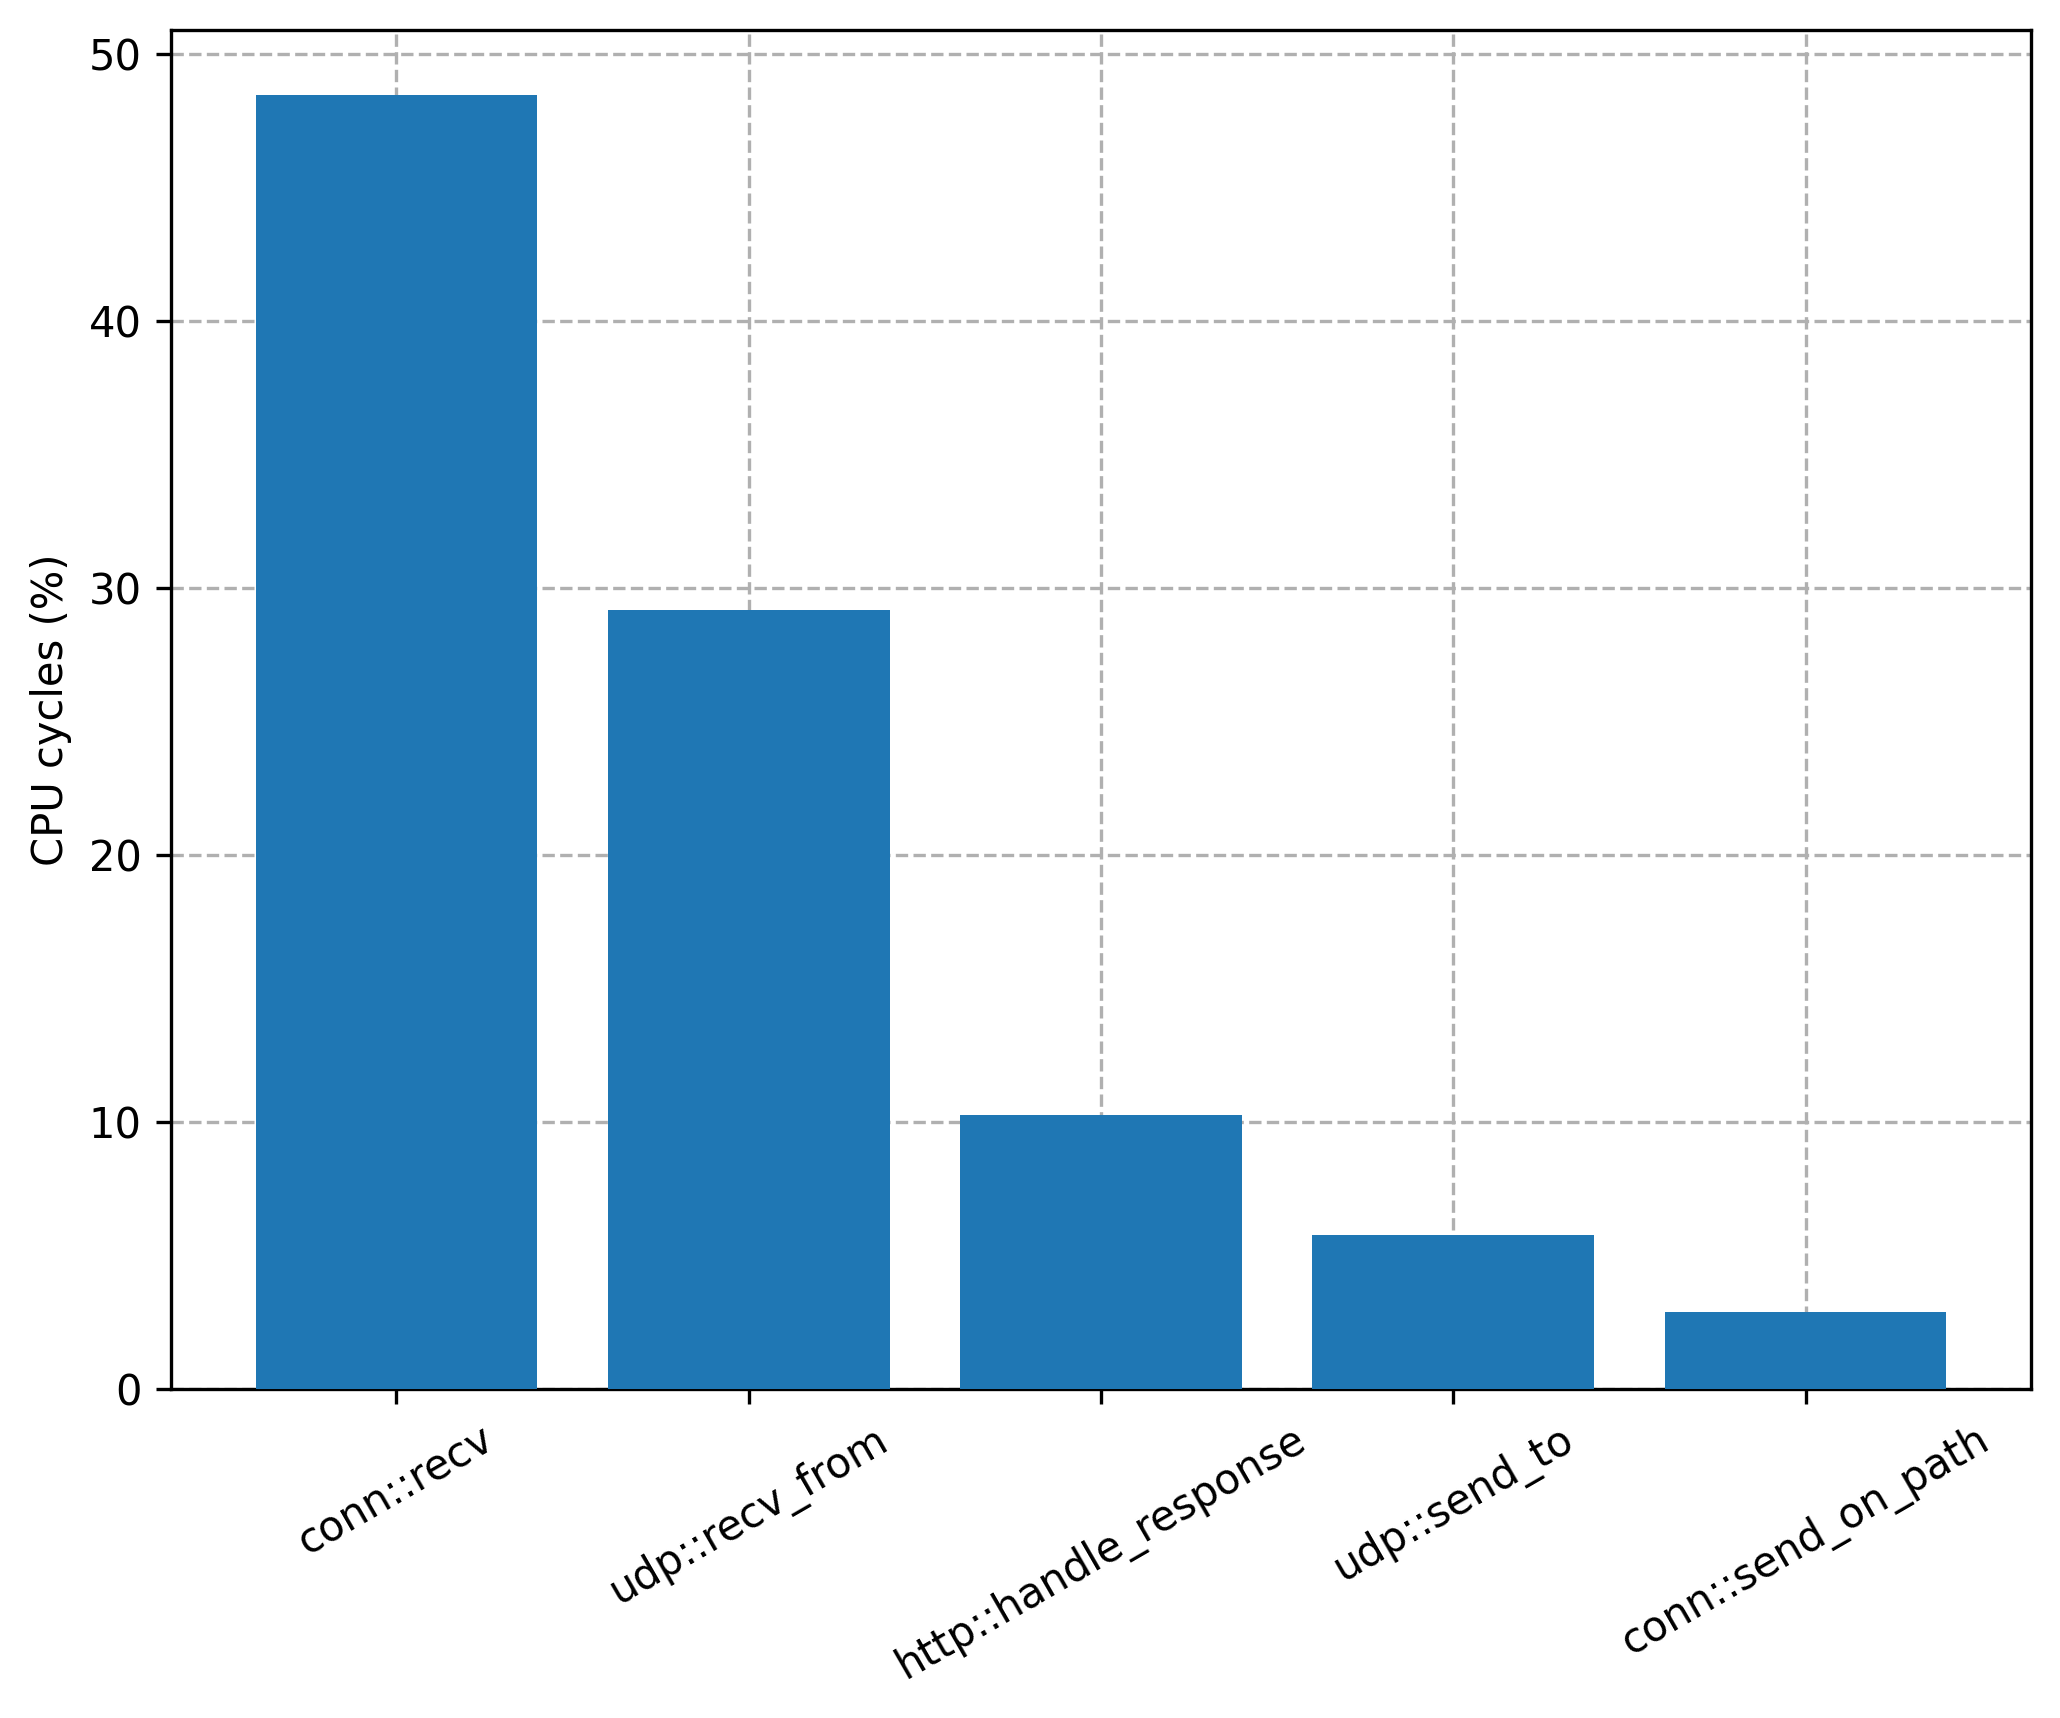

In [5]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
labels = list(mpquic.keys())
values = []
for key in labels:
    values.append(mpquic[key])
ax.bar(labels, values, zorder=3)
ax.set_xticklabels(labels, rotation=30)
ax.set_ylim(bottom=0)
ax.grid(which='major', zorder=0, linestyle="dashed")
ax.set_ylabel('CPU cycles (%)')


### Multithreaded

In [30]:
main_thread = {
    'http': 53.01, 
    'locking': 31.23,  
}
main_thread['other'] = 100 - sum(main_thread.values())

path_thread = {
    'read': 56.95, 
    'locking': 22.28, 
    'write': 6.42
}
path_thread['other'] = 100 - sum(path_thread.values())

In [50]:
def plot_perf_distribution(ax: plt.Axes, data: Dict[str, float], title: str):
    labels = list(data.keys())
    values = []
    for key in labels:
        values.append(data[key])
    ax.bar(labels, values, zorder=3)
    ax.set_xticklabels(labels, rotation=30)
    ax.set_ylabel('CPU cycles (%)')
    ax.set_ylim(bottom=0)
    ax.grid(which='major', zorder=0, linestyle="dashed")
    ax.set_title(title)

/tmp/ipykernel_46227/2950794241.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=30)
/tmp/ipykernel_46227/2950794241.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=30)


Text(0.5, 0.98, 'CPU cycles distribution')

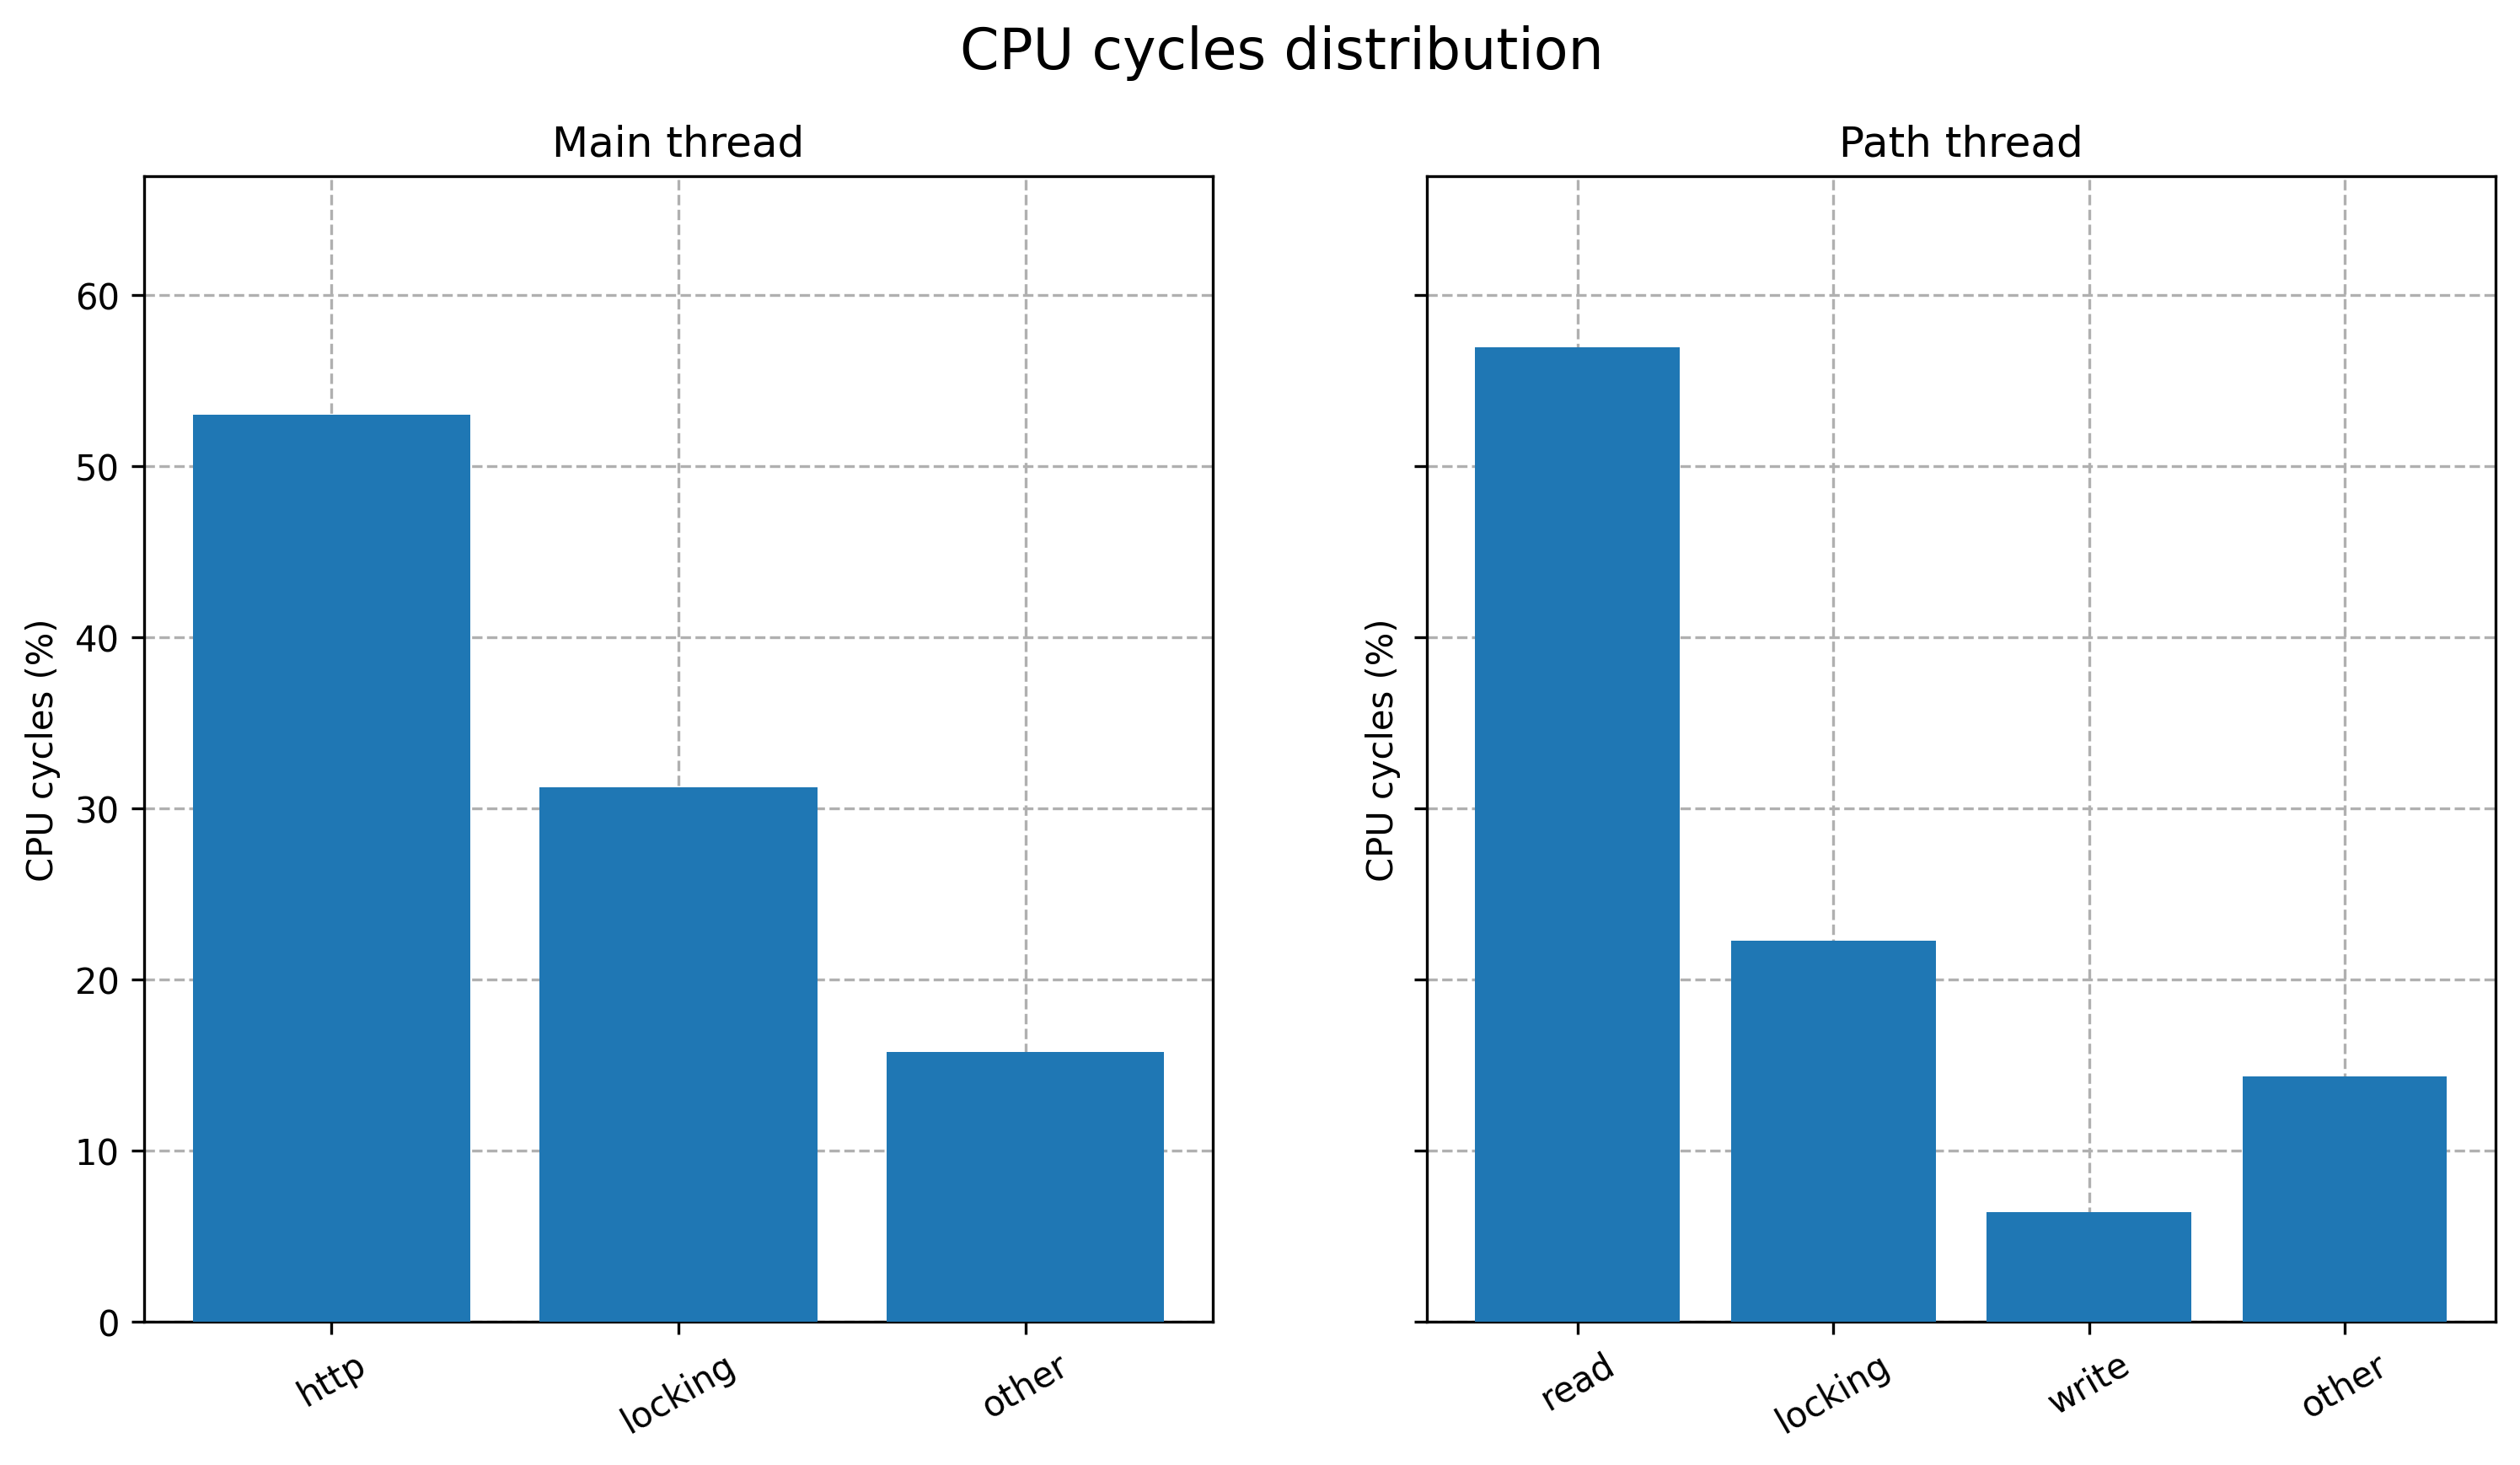

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300, sharey=True)
fig.subplots_adjust(hspace=0.5)  # Add margin between rows
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_perf_distribution(axes[0], main_thread, 'Main thread')
plot_perf_distribution(axes[1], path_thread, 'Path thread')

for ax in axes:
    ax.set_ylim(bottom=0, top=max(max(main_thread.values()), max(path_thread.values())) + 10)
fig.suptitle('CPU cycles distribution', fontsize=16)

## Amdahl's law

/tmp/ipykernel_46227/683063820.py:4: RuntimeWarning: divide by zero encountered in true_divide
  y_p1 = 1/((1-p_1) + p_1/x)
/tmp/ipykernel_46227/683063820.py:7: RuntimeWarning: divide by zero encountered in true_divide
  y_p2 = 1/((1-p_2) + p_2/x)


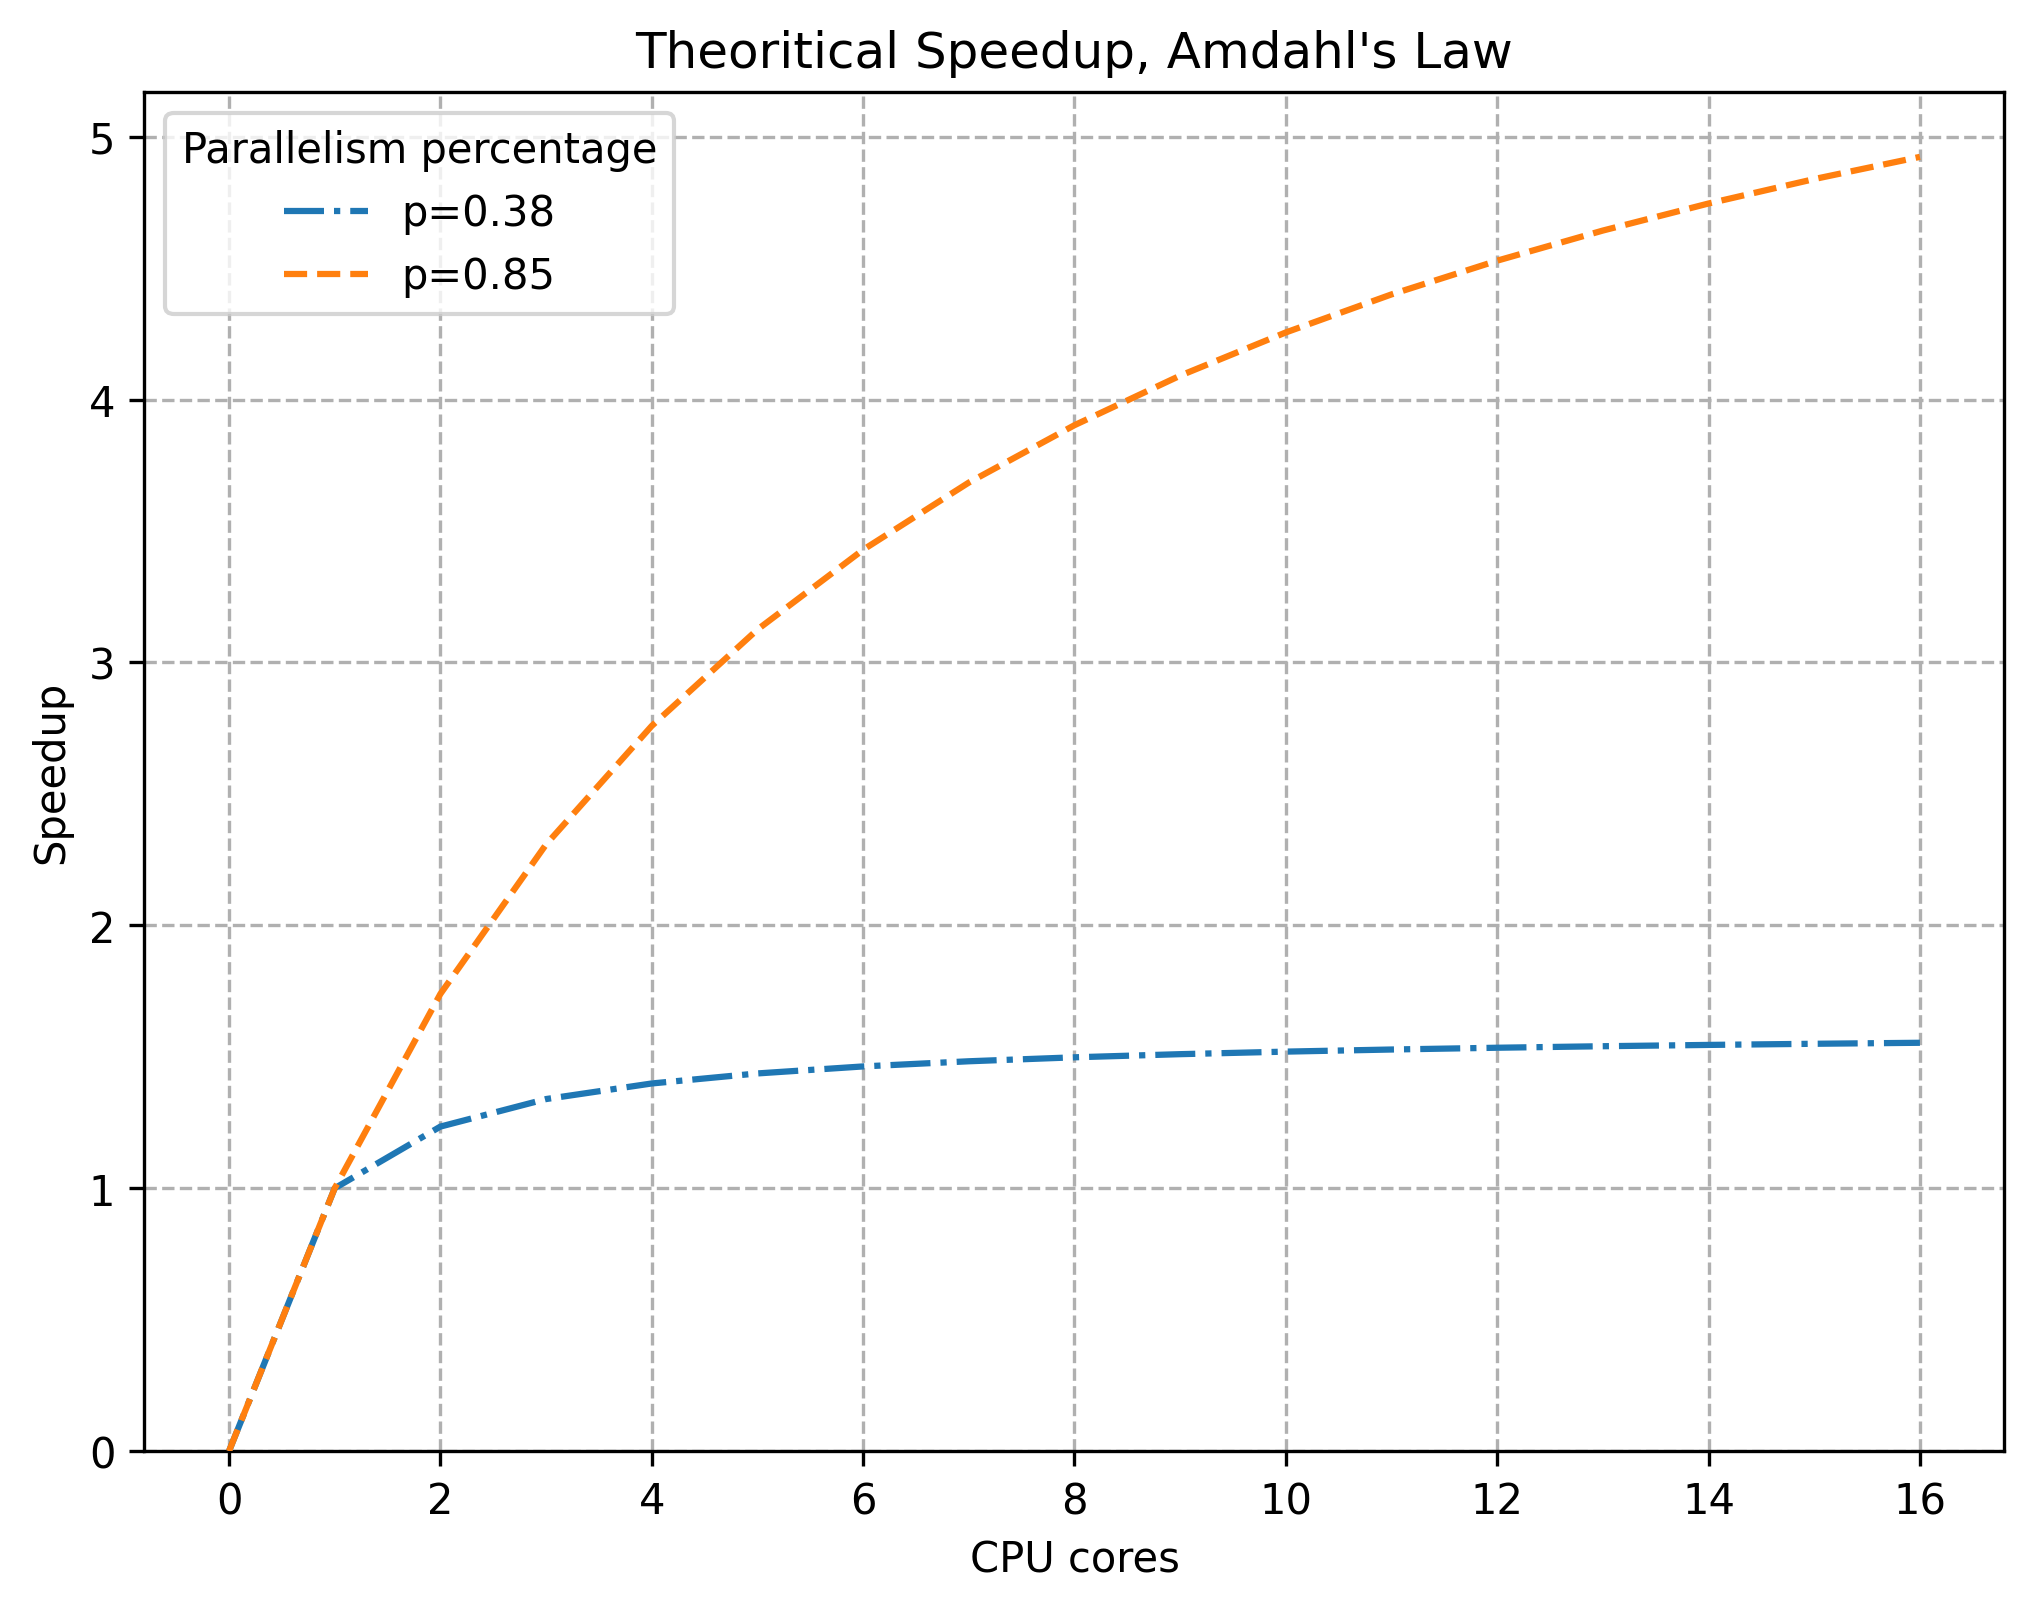

In [28]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
x = np.arange(0, 17)
p_1 = 0.38
y_p1 = 1/((1-p_1) + p_1/x)

p_2 = 0.85
y_p2 = 1/((1-p_2) + p_2/x)
ax.plot(x, y_p1, zorder=3, linestyle="-.", label=f"p={p_1:.2f}")
ax.plot(x, y_p2, zorder=3, linestyle="--", label=f"p={p_2:.2f}")
#ax.plot(rates, exponential_theory, label="Exponential", zorder=3, linestyle="-.", marker="*")
ax.set_xlabel('CPU cores')
ax.set_ylabel('Speedup')
ax.set_title(f'Theoritical Speedup, Amdahl\'s Law')
ax.set_ylim(bottom=0)
ax.legend(title='Parallelism percentage')
ax.grid(which='major', zorder=0, linestyle="dashed")  # Show the major grid behind the plot

In [27]:
y

array([0.        , 1.        , 1.2345679 , 1.33928571, 1.3986014 ,
       1.43678161, 1.46341463, 1.48305085, 1.49812734, 1.51006711,
       1.51975684, 1.52777778, 1.53452685, 1.54028436, 1.54525386,
       1.54958678, 1.55339806])